![Py4Eng](img/logo.png)

# Cython
## Yoav Ram

# [Cython at a glance](http://docs.cython.org/src/userguide/numpy_tutorial.html#cython-at-a-glance)

Cython is a compiler which compiles Python-like code files to C code. Still, ‘’Cython is not a Python to C translator’‘. That is, it doesn’t take your full program and “turns it into C” – rather, the result makes full use of the Python runtime environment. A way of looking at it may be that your code is still Python in that it runs within the Python runtime environment, but rather than compiling to interpreted Python bytecode one compiles to native machine code (but with the addition of extra syntax for easy embedding of faster C-like code).

This has two important consequences:

- **Speed.** How much depends very much on the program involved though. Typical Python numerical programs would tend to gain very little as most time is spent in lower-level C that is used in a high-level fashion. However for-loop-style programs can gain many orders of magnitude, when typing information is added (and is so made possible as a realistic alternative).
- **Easy calling into C code.** One of Cython’s purposes is to allow easy wrapping of C libraries. When writing code in Cython you can call into C code as easily as into Python code.

Some Python constructs are not yet supported, though making Cython compile all Python code is a stated goal (among the more important omissions are inner functions and generator functions).

# Hello world!

Let's start with a simple *Hello World!* to check that everything is working.

We load the `Cython` magic that will allow us to quickly use Cython inside the notebook. The magic is installed with the `cython` package (`conda install cython` or `pip install cython`). The Cython requires that a C compiler is installed and can be found, and on Windows that may be tricky, here are some resources:

- [Install Cython on Windows](https://github.com/cython/cython/wiki/InstallingOnWindows)
- [Install C compiler on Windows](https://github.com/cython/cython/wiki/CythonExtensionsOnWindows)
- [Compiling Python extensions on Windows](https://blog.ionelmc.ro/2014/12/21/compiling-python-extensions-on-windows/)

On Linux/OSX you probably already have a compiler, check with `!gcc --version`. If `gcc` is not found, install it:

- On [Ubuntu](https://help.ubuntu.com/community/InstallingCompilers) you should run `sudo apt-get install build-essential`.
- On CentOS you just need to install development tools: `sudo yum group install "Development Tools"`.

In [1]:
import Cython
print("Cython", Cython.__version__)

%load_ext Cython

Cython 0.25.2


In [2]:
%%cython 
print("Hello World!")

Hello World!


# First Cython example

Let's see a quick example of what Cython can do for us. 

Consider the following Python [function that returns the first `k` prime numbers](http://docs.cython.org/src/tutorial/cython_tutorial.html#primes):

In [3]:
def primes(kmax):
    p = [None]*1000
    result = []
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p[k] = n
            k = k + 1
            result.append(n)
        n = n + 1
    return result

Here is the Cython version of this function; the only addition here is that we use `cdef` to define the types of `n, k, i, p`. This `cdef` statement is used to define **local C variables**. We also add `int` in the arguments list to define the type of `kmax`: this means that any object passed will be **converted to a C integer**.

In [4]:
%%cython
def cprimes(int kmax):
    cdef int n, k, i
    cdef int p[1000]
    result = []
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p[k] = n
            k = k + 1
            result.append(n)
        n = n + 1
    return result

In [5]:
primes(100) == cprimes(100)

True

In [6]:
n = 1000
%timeit primes(n)
%timeit cprimes(n)

10 loops, best of 3: 62.1 ms per loop
1000 loops, best of 3: 1.99 ms per loop


Note that in the inner loop (lines 12-13) only objects with type definitions, and thus C objects, are reffered to; therefore, **the loop is translated entirely into C code**, and runs very fast. Notice that the `cdef`-defined `n` is passed to `result.append`, a method of a Python list object. The conversion is taken care of by Cython.

## Creating a Cython module

We can now put that Cython code into a separate file with extension `pyx`. 

In [8]:
!mkdir ../scripts/cython
%cd ../scripts/cython

/Users/yoavram/Work/Py4Eng/scripts/cython


In [9]:
%%file primes.pyx
def cprimes(int kmax):
    cdef int n, k, i
    cdef int p[1000]
    result = []
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p[k] = n
            k = k + 1
            result.append(n)
        n = n + 1
    return result

Writing primes.pyx


Now we compile it and import it with a single stroke using the [`pyximport` module](http://docs.cython.org/en/latest/src/reference/compilation.html#pyximport),

> Cython code, unlike Python, must be compiled.
> This happens in two stages:
> A .pyx file is compiles by Cython to a .c file.
> The .c file is compiled by a C comiler to a .so file (or a .pyd file on Windows)

In [10]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x111b1add8>)

In [11]:
from primes import cprimes

In [12]:
len(cprimes(100)) == 100

True

You can also do this on your own, without `pyximport`. This is useful when shipping or if you just want to see the C file - for example, to see how much work Cython saved you from doing!

You start by writing a `setup.py` file which imports `cythonize` from the Cython package and tells `setup` (the standard way to setup Python packages, using `distutils` or `setuptools`) to build an extension module using `cythonize`.

In [13]:
%%file setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("primes.pyx")
)

Writing setup.py


Run it with this command, which builds the extension:

In [15]:
!python setup.py build_ext --inplace

Compiling primes.pyx because it changed.
[1/1] Cythonizing primes.pyx
running build_ext
building 'primes' extension
creating build
creating build/temp.macosx-10.9-x86_64-3.6
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/yoavram/miniconda3/envs/Py4Eng/include -arch x86_64 -I/Users/yoavram/miniconda3/envs/Py4Eng/include -arch x86_64 -I/Users/yoavram/miniconda3/envs/Py4Eng/include/python3.6m -c primes.c -o build/temp.macosx-10.9-x86_64-3.6/primes.o
gcc -bundle -undefined dynamic_lookup -Wl,-rpath,/Users/yoavram/miniconda3/envs/Py4Eng/lib -L/Users/yoavram/miniconda3/envs/Py4Eng/lib -headerpad_max_install_names -Wl,-rpath,/Users/yoavram/miniconda3/envs/Py4Eng/lib -L/Users/yoavram/miniconda3/envs/Py4Eng/lib -headerpad_max_install_names -arch x86_64 build/temp.macosx-10.9-x86_64-3.6/primes.o -L/Users/yoavram/miniconda3/envs/Py4Eng/lib -o /Users/yoavram/Work/Py4Eng/scripts/cython/primes.cpython-36m-darwin.so


Let's see what was generated (this might look different on different machines, especially Windows vs. Linux):

In [16]:
%ls

build/                        primes.pyx
primes.c                      setup.py
primes.cpython-36m-darwin.so*


And the actual C file:

In [17]:
%cat primes.c

/* Generated by Cython 0.25.2 */

/* BEGIN: Cython Metadata
{
    "distutils": {},
    "module_name": "primes"
}
END: Cython Metadata */

#define PY_SSIZE_T_CLEAN
#include "Python.h"
#ifndef Py_PYTHON_H
    #error Python headers needed to compile C extensions, please install development version of Python.
#elif PY_VERSION_HEX < 0x02060000 || (0x03000000 <= PY_VERSION_HEX && PY_VERSION_HEX < 0x03020000)
    #error Cython requires Python 2.6+ or Python 3.2+.
#else
#define CYTHON_ABI "0_25_2"
#include <stddef.h>
#ifndef offsetof
  #define offsetof(type, member) ( (size_t) & ((type*)0) -> member )
#endif
#if !defined(WIN32) && !defined(MS_WINDOWS)
  #ifndef __stdcall
    #define __stdcall
  #endif
  #ifndef __cdecl
    #define __cdecl
  #endif
  #ifndef __fastcall
    #define __fastcall
  #endif
#endif
#ifndef DL_IMPORT
  #define DL_IMPORT(t) t
#endif
#ifndef DL_EXPORT
  #define DL_EXPORT(t) t
#endif
#ifndef HAVE_LONG_LONG
  #if PY_VERSION_HEX >= 0x03030000 || (PY_MAJOR_VERSION == 2 && PY_

You can now import `primes` as if it was a regular Python module (if you aren't sure which of the things you are importing, restart your kernel, but don't forger to change directory to `../scripts/cython`).

In [18]:
import primes

In [19]:
primes.cprimes(10)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

# Another example

This is from Robert Bradshaw [SciPy 2008 slides](http://wiki.sagemath.org/scipy08?action=AttachFile&do=get&target=scipy-cython.tgz).

We will write a simple integration code to integrate $f(x) = x^3 - 3x$:

In [20]:
def f(x):
    return x * x * x - 3 * x

def integrate_f(a , b , N):
    s = 0
    dx = (b - a )/ N
    for i in range(N):
        s += f(a + i * dx)
    return s * dx

In [21]:
%timeit integrate_f(0, 1, 10000)

100 loops, best of 3: 4.33 ms per loop


Now, the same with Cython. Note that when we define a function with `cdef` we can set a return value but we can only call it from within Cython. When we define a function with `def` we can import it and call it from Python.

In [22]:
%%cython
cdef double g(double x):
    return x * x * x - 3* x

def integrate_g(double a , double  b , int N):
    cdef double s = 0
    cdef double dx = (b - a )/ N
    cdef int i
    for i in range(N):
        s += g( a + i * dx )
    return s * dx

In [23]:
%timeit integrate_g(0, 1, 10000)

100000 loops, best of 3: 19.5 µs per loop


Now let's integrate 
$$
\int_a^b{\frac{\sin{x}}{x}}
$$

Without Cython, we should use either `math.sin` or `numpy.sin`:

In [24]:
import numpy as np

def f(x):
    return np.sin(x) / x

integrate_f(1, 2, 1000)

0.65952330638545142

With Cython, we can import some C functions using an `extern` block:

In [25]:
%%cython
cdef extern from "math.h":
    double sin(double)
    double cos(double)
    
cdef double g(double x):
    return sin(x)/x

def integrate_g(double a , double  b , int N):
    cdef double s = 0
    cdef double dx = (b - a) /  N
    cdef int i
    for i in range(N):
        s += g(a + i * dx)
    return s * dx

In [26]:
%timeit integrate_f(1, 3, 1000)
%timeit integrate_g(1, 3, 1000)

100 loops, best of 3: 3.18 ms per loop
10000 loops, best of 3: 47.1 µs per loop


# Cython + NumPy

Cython works well with NumPy.

Let's loop over a NumPy array:

In [27]:
def summ(x):
    s = 0
    for i in range(x.shape[0]):
        s += x[i]
    return s

In [28]:
%%cython
cimport numpy as np

def csumm(x):
    cdef np.ndarray[long, ndim=1] arr = x
    cdef int i = 0
    cdef long s = 0
    for i in range(arr.shape[0]):
        s += arr[i]
    return s

In [29]:
x = np.random.randint(0, 9, 100000)
%timeit summ(x)
%timeit csumm(x)

10 loops, best of 3: 94.7 ms per loop
1000 loops, best of 3: 498 µs per loop


Note that if you would type `s` and `arr` as made of `int` you would get an error because Python's `int` is a C `long`... But you would get a `ValueError`, not a segmentation fault or anything like that. Here's an example:

In [30]:
y = np.array([0.1, 0.2, 0.3])
csumm(y)

ValueError: Buffer dtype mismatch, expected 'long' but got 'double'

# Example: Mandelbrot fractal

In [31]:
import numpy as np

def mandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [32]:
%%cython
cimport numpy as np

def cmandelbrot(int[:,::1] m,
                int size,
                int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if z.real**2 + z.imag**2 <= 100:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [33]:
size = 200
iterations = 100
m = np.zeros((size, size), dtype=np.int32)

In [34]:
%timeit -n 1 -r 1 mandelbrot(m, size, iterations)
%timeit -n 1 -r 1 cmandelbrot(m, size, iterations)

1 loop, best of 1: 8.71 s per loop
1 loop, best of 1: 7.12 ms per loop


In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

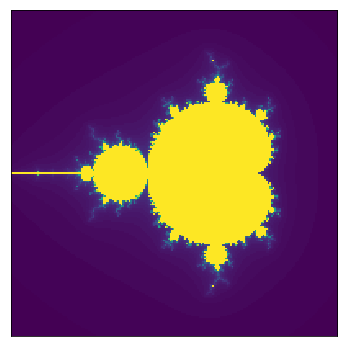

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(m, cmap='viridis')
ax.set(xticks=[], yticks=[]);

## Numba

In [37]:
import numba
print("Numba", numba.__version__)

Numba 0.31.0


In [38]:
import numpy as np

@numba.jit()
def numandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [39]:
%timeit -n 1 -r 3 mandelbrot(m, size, iterations)
%timeit cmandelbrot(m, size, iterations)
%timeit numandelbrot(m, size, iterations)

1 loop, best of 3: 6.2 s per loop
100 loops, best of 3: 6.67 ms per loop
The slowest run took 66.40 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 10 ms per loop


In [40]:
%timeit numandelbrot(m, size, iterations)

100 loops, best of 3: 7.48 ms per loop


# Exercise

In the [image processing session](image-processing.ipynb) we had an exercise to write a dilation filter using SciPy's `generic_filter` function.

The idea was to pass `genetic_filter` a max function so that it will become a dilation filter, using either `generic_filter(denoised, max, size=(k, k))` or `generic_filter(denoised, np.max, size=(k, k))`. A naive guess might be that the NumPy version is faster, as it uses NumPy's `max` rather than the pure-Python version.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import generic_filter

def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])

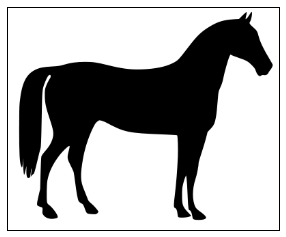

In [6]:
import skimage.data
horse = skimage.data.horse()[:,:,0]
display_image(horse)

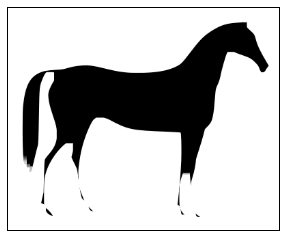

In [63]:
dilated = generic_filter(horse, max, size=(10, 10))
display_image(dilated)

In [64]:
%timeit generic_filter(horse, max, size=(10, 10))

1 loop, best of 3: 4.99 s per loop


However, NumPy's `max` (and many other functions) are optimized for big arrays and include type and bounds checking. So the regular Python `max` is faster, and we can do even better by implementing max with Cython.

Implement a `cmax` function using Cython and give it to `genetic_filter` to gain a 4-fold speed advantage of ver NumPy. The solution is in [cython_max.pyx](../solutions/cython_max.pyx).

In [9]:
%%cython


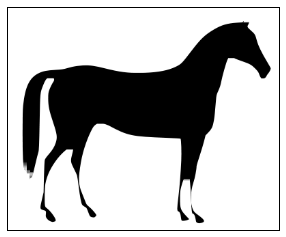

In [72]:
display_image(generic_filter(horse, cmax, size=(10, 10), extra_arguments=(9,)))

In [74]:
%timeit generic_filter(horse, max, size=(3, 3))
%timeit generic_filter(horse, np.max, size=(3, 3))
%timeit generic_filter(horse, cmax, size=(3, 3), extra_arguments=(9,))

1 loop, best of 3: 808 ms per loop
1 loop, best of 3: 1.79 s per loop
1 loop, best of 3: 495 ms per loop


# Bounds checking

We can also ask Cython to avoid checking bounds when accessing arrays and lists.

In [3]:
%pwd

'/Users/yoavram/Work/Py4Eng/sessions'

In [3]:
import scipy.misc
scipy.misc.imread?

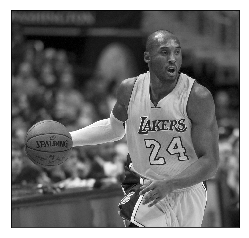

In [4]:
from scipy.misc import imread
# original image from https://upload.wikimedia.org/wikipedia/commons/5/56/Kobe_Bryant_2014.jpg
image = imread('../data/Kobe_Bryant_2014.jpg', flatten=True).astype(float) # greyscale
display_image(image)

In [6]:
def segment_np(image, threshold):
    output = np.zeros_like(image)
    output[image > threshold] = 255
    return output

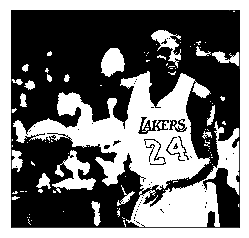

In [9]:
display_image(segment_np(image, 100))

In [52]:
%%cython
import numpy as np

cdef void _segment(double[:,:] image, int n, int m, double threshold, double[:,:] output):
    cdef int i, j
    for i in range(n):
        for j in range(m):
            if image[i, j] > threshold:
                output[i, j] = 255
            else:
                output[i, j] = 0

def segment_cy(image, threshold):
    output = np.zeros_like(image)
    n, m = image.shape
    _segment(image, n , m, threshold, output)
    return output

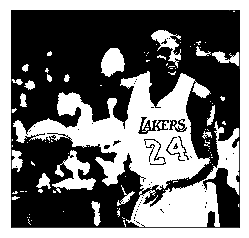

In [53]:
display_image(segment_cy(image, 100))

In [54]:
%timeit -n 1 segment_np(image, 100)
%timeit -n 1 segment_cy(image, 100)

1 loop, best of 3: 2.2 ms per loop
1 loop, best of 3: 1.61 ms per loop


In [8]:
%%cython
import numpy as np
cimport cython

@cython.boundscheck(False)
cdef void _segment2(double[:,:] image, unsigned int n, unsigned int m, double threshold, double[:,:] output):
    cdef unsigned int i, j
    for i in range(n):
        for j in range(m):
            if image[i, j] > threshold:
                output[i, j] = 255
            else:
                output[i, j] = 0

def segment_cy2(image, threshold):
    output = np.zeros_like(image)
    n, m = image.shape
    _segment2(image, n , m, threshold, output)
    return output

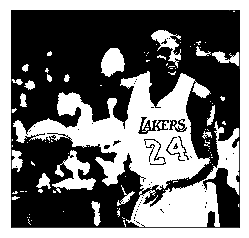

In [56]:
display_image(segment_cy2(image, 100))

In [57]:
%timeit segment_np(image, 100)
%timeit segment_cy(image, 100)
%timeit segment_cy2(image, 100)

100 loops, best of 3: 2.32 ms per loop
100 loops, best of 3: 1.91 ms per loop
1000 loops, best of 3: 1.86 ms per loop


You can explore other [compiler directives](https://github.com/cython/cython/wiki/enhancements-compilerdirectives) such as `wraparound` and `nonecheck`.

# Releasing the GIL

Cython can be directed to [release the GIL](http://docs.cython.org/src/userguide/external_C_code.html#acquiring-and-releasing-the-gil), thus enabling multiple threads to run in parallel (if the OS allows it) and achieve performence gain even in comparison to multi-processing, as threads are cheaper than processes and thread communication is faster than process communication.

In [6]:
import multiprocessing
multiprocessing.cpu_count

import contextlib
import time

@contextlib.contextmanager
def tictoc():
    tic = time.time()
    yield tic
    toc = time.time()
    print("Elapsed {} seconds".format(toc - tic))

Of course, this would just slow things down if the CPU count above is 1.

In [10]:
%%cython
import numpy as np
cimport cython

@cython.boundscheck(False)
cdef void _segment2(double[:,:] image, unsigned int n, unsigned int m, double threshold, double[:,:] output):
    cdef unsigned int i, j
    for i in range(n):
        for j in range(m):
            if image[i, j] > threshold:
                output[i, j] = 255
            else:
                output[i, j] = 0

def _segment_cy3(image, threshold, output):
    n, m = image.shape
    _segment2(image, n , m, threshold, output)

In [11]:
from concurrent.futures import ThreadPoolExecutor, wait
from multiprocessing import cpu_count
print("CPUs:", cpu_count())

def segment_cy3(image, threshold, cores=cpu_count()):
    n, m = image.shape
    output = np.empty_like(image)
    ns = np.arange(0, n, 1, dtype=int)
    with ThreadPoolExecutor(cores) as executor:
        futures = [
            executor.submit(
                _segment_cy3, image[start_n:stop_n], threshold, output[start_n:stop_n]
            )
            for start_n, stop_n in zip(ns[:-1], ns[1:])
        ]
        wait(futures)
    return output

CPUs: 4


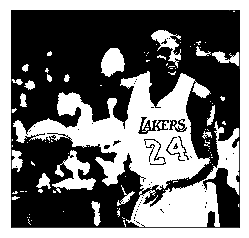

In [12]:
display_image(segment_cy3(image, 100))

Let's try it on a bigger image by resizing our image:

In [13]:
from skimage.transform import resize

In [15]:
n, m = image.shape
big_image = resize(image, (32*n, 32*m))
print(image.size, "->", big_image.size)

849600 -> 869990400


In [16]:
with tictoc():
    segment_cy2(big_image, 100)

Elapsed 47.69877910614014 seconds


In [17]:
with tictoc():
    segment_cy3(big_image, 100)

Elapsed 19.747546195983887 seconds


If we resize by less than 32-fold then `segment_cy2` is faster than `segment_cy3`, at least in my tests.

# References

- [Cython language basics](http://docs.cython.org/src/userguide/language_basics.html#language-basics)
- [Cython for NumPy users](http://docs.cython.org/src/userguide/numpy_tutorial.html#numpy-tutorial) offers a 2D convolve example.
- [IPython Cookbook](https://ipython-books.github.io/cookbook/) by Cyrille Rossant has a full chapter on high performance computing. with many [notebook examples](https://github.com/ipython-books/cookbook-code/tree/master/notebooks/chapter05_hpc) and a more complicated Cython example.
- [Numba](http://numba.pydata.org/)
- [Numexpr](https://github.com/pydata/numexpr/wiki/Numexpr-Users-Guide)
- [Blaze Ecosystem](http://blaze.pydata.org/)
- Jake Vanderplas's [Cython project template](https://github.com/jakevdp/cython_template) can help you build projects that use Cython.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.0, [IPython](http://ipython.org/) 5.2.2, [Jupyter](http://jupyter.org) 4.3.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)